In [1]:
#This is an unfinished, experimental notebook!
#Testing plot functions for skyfield, using Basemap

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from skyfield.api import now, earth, Star, NamedStar
import ephem
import skyfield
import skyfield.data
from IPython.html.widgets import interact, interactive, fixed
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

In [ ]:
%pylab inline

In [5]:
s=ephem.star('Dubhe')
s.compute(2000,2000)
#-degrees(s.a_ra),degrees(s.a_dec)

In [11]:
#Experiment with basemap projections, show various map parameters with grid lines only
def show_map(lat_0=0,lon_0=0, width=12000000, height=8000000):
    m = Basemap(projection='aeqd', width=width, height=height,
                lat_0=lat_0, lon_0=lon_0)
    m.drawparallels(np.arange(-80,80,10))
    m.drawmeridians(np.arange(-180,180,10))

<function __main__.show_map>

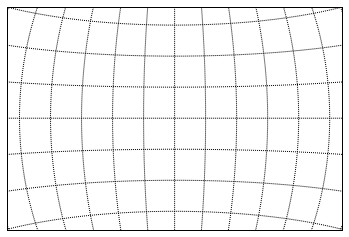

In [12]:
interact(show_map, lat_0=(0,90,5), lon_0=(0,90,5))

In [13]:
#Use pyephem to get the stars of the big dipper
names = ['Dubhe', 'Merak', 'Phecda', 'Megrez',
         'Alioth', 'Mizar', 'Alcor', 'Alcaid',]
stars = [ephem.star(name) for name in names]

In [14]:
#Use pyephem to plot the big dipper
def dipper_radec(year, epoch):
    for star in stars:
        star.compute(str(year), str(epoch))
    ra = [-degrees(star.a_ra) for star in stars]
    dec = [degrees(star.a_dec) for star in stars]
    return ra, dec
    
def plot_dipper(year, epoch, projection='aeqd'):
    ra, dec = dipper_radec(year, epoch)
    width = 4000000
    m = Basemap(width=width, height=width, projection=projection,
                lat_0=dec[3], lon_0=ra[3])
    m.drawparallels(np.arange(-80,81,10))
    m.drawmeridians(np.arange(-180,180,10))
    x, y = m(ra, dec)
    m.plot(x, y, marker='o', linestyle='--', color='b')
    plt.title('date={} epoch={}'.format(year,epoch))


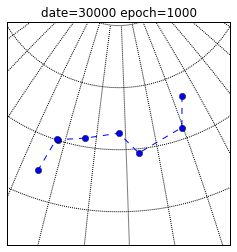

In [15]:
#Use interact to show the evolution of the big dipper over large time scale (powered by pyEphem)
interact(plot_dipper, year=(-100000,100000,5000), epoch=(-2000,4000,1000),
         projection=['cyl','aeqd','laea','merc','stere','ortho', 'robin', 'gnom'])

In [16]:
#Now calculate the big dipper using skyfield rather than pyEphem
import skyfield.data.hipparcos

In [17]:
#['Dubhe', 'Merak', 'Phecda', 'Megrez', 'Alioth', 'Mizar', 'Alcor', 'Alkaid',]
dipper_ids = [54061, 53910, 58001, 59774, 62956, 65378, 65477, 67301]

In [18]:
#dipper_stars=skyfield.data.hipparcos.get([str(x) for x in dipper_ids])
dipper_stars=[skyfield.data.hipparcos.get(str(x)) for x in dipper_ids]
dipper_stars

[Star(ra_hours=11.062130192490221, dec_degrees=61.75103320112995, ra_mas_per_year=-136.46, dec_mas_per_year=-35.25, parallax_mas=26.38, names=[('HIP', 54061)]),
 Star(ra_hours=11.030687999605183, dec_degrees=56.382426786427374, ra_mas_per_year=81.66, dec_mas_per_year=33.74, parallax_mas=41.07, names=[('HIP', 53910)]),
 Star(ra_hours=11.897179848125406, dec_degrees=53.694760084185177, ra_mas_per_year=107.76, dec_mas_per_year=11.16, parallax_mas=38.99, names=[('HIP', 58001)]),
 Star(ra_hours=12.257100034120432, dec_degrees=57.03261690178644, ra_mas_per_year=103.56, dec_mas_per_year=7.81, parallax_mas=40.05, names=[('HIP', 59774)]),
 Star(ra_hours=12.900485951888628, dec_degrees=55.959821158352696, ra_mas_per_year=111.74, dec_mas_per_year=-8.99, parallax_mas=40.3, names=[('HIP', 62956)]),
 Star(ra_hours=13.398761920264775, dec_degrees=54.925361752393151, ra_mas_per_year=121.23, dec_mas_per_year=-22.01, parallax_mas=41.73, names=[('HIP', 65378)]),
 Star(ra_hours=13.420427210362131, dec_deg

In [19]:
dubhe=dipper_stars[0]

In [20]:
earth(skyfield.api.JulianDate(utc=date(2015,1,1))).observe(dubhe).radec()

(<Angle 11h 03m 43.38s>, <Angle +61deg 45' 03.2">, <Distance 7.81898e+06 au>)

In [21]:
#Plot big dipper with skyfield
def skyfield_dipper(year, projection='aeqd'):
    ra = []
    dec = []
    for star in dipper_stars:
        r,d,z = earth(skyfield.api.JulianDate(utc=date(year,1,1))).observe(star).radec()
        ra.append(r._degrees)
        dec.append(d.degrees)
    width = 4000000
    m = Basemap(width=width, height=width, projection=projection,
                lat_0=dec[3], lon_0=ra[3])
    m.drawparallels(np.arange(-80,81,10))
    m.drawmeridians(np.arange(-180,180,10))
    x, y = m(ra, dec)
    m.plot(x, y, marker='o', linestyle='--', color='b')
    plt.title('date={} epoch={}'.format(year,'2000'))

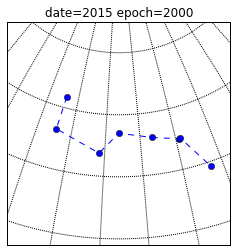

In [22]:
skyfield_dipper(2015)

In [23]:
#Try to use skyfield to show long term evolution of big dipper
#TODO: won't work, since this method requires a long term earth ephemeris. Switch to using solar system 
interact(skyfield_dipper, year=(-10000,10000,1000))

DateError: ephemeris DE421 only covers dates 2414992.5 through 2524624.5

In [ ]:
NamedStar("Polaris")

In [24]:
#Function to try to plot a skychart, by determing the rectangular boundary
def skychart(objects, viewer, date ,projection='aeqd', linestyle='',
             parallels = np.arange(-80,80,10), meridians = np.arange(-180,180,10),
             mag=1.1):
    ra = []
    dec = []
    for o in objects:
        r,d,z = viewer(date).observe(o).radec()
        ra.append(r._degrees)
        dec.append(d.degrees)
    #width = 4000000
    #print np.average(ra)
    #print np.average(dec)
    m = Basemap(
        urcrnrlat=np.max(dec) * mag,         urcrnrlon=np.max(ra) * mag,
        llcrnrlat=np.min(dec) * (1.0 / mag), llcrnrlon=np.min(ra) * (1.0 / mag),
        lat_0=np.average(dec), lon_0=np.average(ra),
        projection=projection,
        celestial=True
    )
    m.drawparallels(parallels)
    m.drawmeridians(meridians)
    x, y = m(ra, dec)
    m.plot(x, y, marker='o', linestyle=linestyle, color='b')
    #plt.title('date={} epoch={}'.format(year,'2000'))
    print m.rmajor,m.rminor

6370997.0 6370997.0


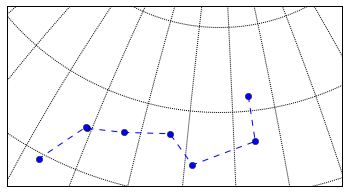

In [25]:
skychart(dipper_stars, earth, skyfield.api.JulianDate(utc=date(2015,1,1)), linestyle='--', mag=1.1)

6370997.0 6370997.0


<function __main__.try_mag>

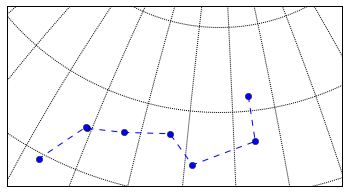

In [26]:
def try_mag(mag=1.1):
    skychart(dipper_stars, earth, skyfield.api.JulianDate(utc=date(2015,1,1)), linestyle='--', mag=mag)
interact(try_mag, mag=(0.25,2.0, .05))

In [27]:
#Function to try to generate a skychart, via a set of objects and a FOV
def skychart_fov(objects, viewer, date ,projection='aeqd', linestyle='',
             parallels = np.arange(-80,80,10), meridians = np.arange(-180,180,10),
             fov=10,r_e= 6370997):
    ra = []
    dec = []
    xyz = 0.0
    for o in objects:
        p = viewer(date).observe(o)
        xyz = xyz + p.position.au
        r,d,z = p.radec()
        ra.append(r._degrees)
        dec.append(d.degrees)
    #width = 4000000
    #print np.average(ra)
    #print np.average(dec)
    #Average doesn't work for angles
    #correct to do is to add up x,y,z vectors, then turn to angle
    from skyfield.positionlib import ICRS
    center = ICRS(xyz)
    #lat_0=np.average(dec)
    #lon_0=np.average(ra)
    c_ra, c_dec, au = center.radec()
    lat_0 = c_dec.degrees
    lon_0 = c_ra._degrees
    r_e = r_e # Radius of Earth in meters
    width = np.pi * r_e * fov / 180.0
    m = Basemap(
        #urcrnrlat=np.clip(lat_0 + fov, -90, 90),  urcrnrlon=np.clip(lon_0 + fov, 0, 360),
        #llcrnrlat=np.clip(lat_0 - fov, -90, 90),  llcrnrlon=np.clip(lon_0 - fov, 0, 360),
        height=width , width=width,
        lat_0=lat_0, lon_0=-lon_0, #watch out for basemap bug with celestial=True
        projection=projection,
        celestial=True
    )
    m.drawparallels(parallels)
    m.drawmeridians(meridians)
    x, y = m(ra, dec)
    m.plot(x, y, marker='o', linestyle=linestyle, color='b')
    m.plot(*m(lon_0, lat_0), marker='o',color='r')
    #plt.title('date={} epoch={}'.format(year,'2000'))
    #print dec
    #print ra
    print "ICRS", center.radec()
    print "center",lat_0,lon_0
    print "ur",m.urcrnrlat,m.urcrnrlon
    print "ll",m.llcrnrlat,m.llcrnrlon
    print "ptp objects   ", np.ptp(dec),np.ptp(ra)
    print "ptp projection", np.ptp([m.urcrnrlat,m.llcrnrlat]), np.ptp([m.urcrnrlon,m.llcrnrlon])
    print "width",width
    print "basemap radius", m.rmajor,m.rminor

ICRS (<Angle 12h 29m 42.24s>, <Angle +56deg 41' 22.2">, <Distance 4.42415e+07 au>)
center 56.6895029686 187.426000705
ur 66.1849341333 -120.010308127
ll 30.3555240213 146.976042638
ptp objects    12.437691181 41.4234426445
ptp projection 35.829410112 266.986350765
width 5003769.34281
basemap radius 6370997.0 6370997.0


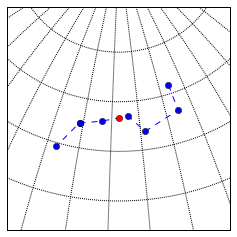

In [28]:
def try_fov(fov=10,r_e=6370997):
    skychart_fov(dipper_stars, earth, skyfield.api.JulianDate(utc=date(2015,1,1)), linestyle='--', fov=fov, r_e=r_e,
                projection='aeqd')
interact(try_fov, fov=(1,180,1), r_e=(0, 80071009, 1071009))

(1.0777563469488143, 2.8960374929568427)
(0.98406163956788206, 2.8878381193113376)
(0.93715133591885413, 3.1146877900599015)
(0.9954076918761855, 3.2089153142666893)
(0.97668263206442818, 3.3773541005107068)
(0.95862694850436325, 3.5078033282333196)
(0.9597198216820223, 3.513475198374282)
(0.86067781073400151, 3.6108134850915605)


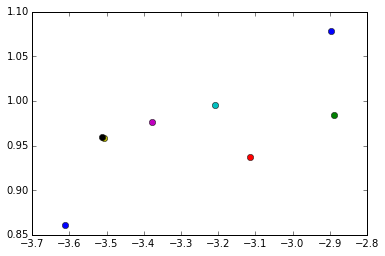

In [30]:
#Try to plot dipper stars with no projection
for s in dipper_stars:
    xyz = earth(utc=(2015,4,1)).observe(s).position.au
    from skyfield.functions import to_polar
    d, a, b = to_polar(xyz)
    print(a,b)
    plot(-b, a, marker='o')

(1.3607543440389445, 4.123933651492468)
(1.3602429892209242, 4.5769110143132306)
(1.4674052406240647, 5.1764659026933213)
(1.5362281335846604, 4.5122491707235906)
(1.5105954050684955, 1.4020872197249139)
(1.4345578525189258, 1.442275717217212)
(1.4318089246166625, 1.4572947038222905)
(1.3305338961990072, 1.1497017429958818)


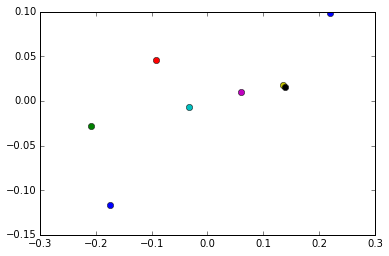

In [31]:
#Try to approximate aeqd distribution without basemap
for s in dipper_stars:
    xyz = earth(utc=(2015,4,1)).observe(s).position.au
    from skyfield.functions import to_polar, rot_z, rot_y
    xyz = rot_z(-187.426000705 * pi / 180.0).dot(xyz)
    xyz = rot_y(-(90.0 - 56.6895029686) * pi / 180.0).dot(xyz)
    d, a, b = to_polar(xyz)
    print(a,b)
    a = pi / 2.0 - a
    x = a * sin(b)
    y = a * cos(b)
    #plot(-b, a, marker='o')
    plot(x, y, marker='o')

In [32]:
xyz = array([0,1,0])
rot_z(-pi/2).dot(xyz)

array([  1.00000000e+00,   6.12323400e-17,   0.00000000e+00])